We show how to use `rasterstats` to obtain statistics within a segment. Although `rasterstats` has a nice API, particularly for beginners, it is extremely slow and not suitable in our opinion for large study areas.

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rasterstats import zonal_stats
from rasterio.plot import show
import geopandas as gpd
import pandas as pd

# Setup Data Directory

In [2]:
data_path_name = 'data/datacube_ROI/'
data_path = Path(data_path_name)
data_path.exists()

True

In [3]:
tif_paths = sorted(list(data_path.glob('*.tif')))
tif_paths

[PosixPath('data/datacube_ROI/ALOS1_RTC_HH_201143_tv.tif'),
 PosixPath('data/datacube_ROI/ALOS1_RTC_HV_201143_tv.tif'),
 PosixPath('data/datacube_ROI/ALOS1_RTC_VV_201143_tv.tif'),
 PosixPath('data/datacube_ROI/hansen_3.tif'),
 PosixPath('data/datacube_ROI/hansen_4.tif'),
 PosixPath('data/datacube_ROI/hansen_5.tif'),
 PosixPath('data/datacube_ROI/hansen_7.tif')]

In [4]:
output_path_name = 'out'
out_path = Path(output_path_name)
out_path.mkdir(exist_ok=True, parents=True)

# Read the Superpixel Vector Data

In [5]:
superpixels_path = str(out_path/'superpixels')
superpixel_df = gpd.read_file(superpixels_path)
superpixel_df.head()

,label,geometry
0,1,"POLYGON ((658337.375 3283734.5, 658362.375 328..."
1,2,"POLYGON ((658212.375 3283709.5, 658224.875 328..."
2,4,"POLYGON ((658237.375 3283672, 658374.875 32836..."
3,3,"POLYGON ((658037.375 3283672, 658112.375 32836..."
4,8,"POLYGON ((657849.875 3283597, 658137.375 32835..."


We will plot it, though the region of interest is so large that's its hard to get an idea of how well the segments are capturing the features. Better to open in QGIS.

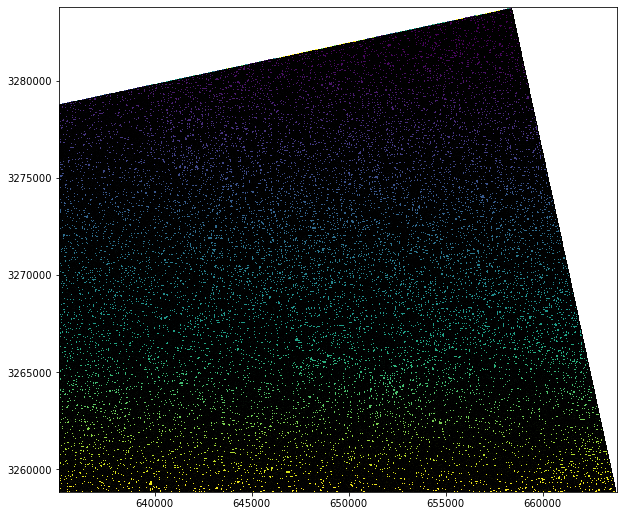

In [6]:
fig, ax = plt.subplots(figsize=(10, 10))
with rasterio.open(tif_paths[0]) as ds:
    show(ds, vmin=0, vmax=.5, ax=ax)
    superpixel_df.plot(ax=ax, column='label', edgecolor='black', facecolor=(0, 0, 0, 0))

# Aggregating the Data

We are only going to use the radar data. Each aggregation takes roughly as long for the entire previous notebook to run.

In [7]:
%%time

zonal_stats_hh = zonal_stats(superpixel_df, tif_paths[0], stats=['std', 'mean'])
zonal_stats_hh = [{'mean_hh': data['mean'], 
                   'std_hh': data['std']} for data in zonal_stats_hh]
df_hh_superpixels = pd.DataFrame(zonal_stats_hh)

CPU times: user 3min 18s, sys: 17.6 s, total: 3min 35s
Wall time: 3min 35s


In [8]:
%%time

zonal_stats_hv = zonal_stats(superpixel_df, tif_paths[1], stats=['std', 'mean'])
zonal_stats_hv = [{'mean_hv': data['mean'],
                   'std_hv': data['std']} for data in zonal_stats_hv]
df_hv_superpixels = pd.DataFrame(zonal_stats_hv)

CPU times: user 3min 16s, sys: 17.4 s, total: 3min 33s
Wall time: 3min 34s


In [9]:
%%time

zonal_stats_vv = zonal_stats(superpixel_df, tif_paths[2], stats=['std', 'mean'])
zonal_stats_vv = [{'mean_vv': data['mean'],
                   'std_vv': data['std']} for data in zonal_stats_vv]
df_vv_superpixels = pd.DataFrame(zonal_stats_vv)

CPU times: user 3min 15s, sys: 17.3 s, total: 3min 32s
Wall time: 3min 33s


## Combining Zonal Stats into Superpixel GeoDataframe

In [11]:
superpixel_analysis_df = pd.concat([superpixel_df,
                                    df_hh_superpixels,
                                    df_hv_superpixels], axis=1)
superpixel_analysis_df.head()

,label,geometry,mean_hh,std_hh,mean_hv,std_hv
0,1,"POLYGON ((658337.375 3283734.5, 658362.375 328...",0.100551,0.048516,0.016197,0.004469
1,2,"POLYGON ((658212.375 3283709.5, 658224.875 328...",0.254946,0.077580,0.034064,0.007196
2,4,"POLYGON ((658237.375 3283672, 658374.875 32836...",0.210932,0.039933,0.037824,0.004866
3,3,"POLYGON ((658037.375 3283672, 658112.375 32836...",0.123295,0.027706,0.034528,0.006364
4,8,"POLYGON ((657849.875 3283597, 658137.375 32835...",0.128836,0.046190,0.029848,0.006000


## Adding `db` column 

In [12]:
superpixel_analysis_df['mean_hh_db'] = superpixel_analysis_df['mean_hh'].map(lambda val: 10 * np.log10(val))
superpixel_analysis_df['mean_hv_db'] = superpixel_analysis_df['mean_hv'].map(lambda val: 10 * np.log10(val))
superpixel_analysis_df.head()

,label,geometry,mean_hh,std_hh,mean_hv,std_hv,mean_hh_db,mean_hv_db
0,1,"POLYGON ((658337.375 3283734.5, 658362.375 328...",0.100551,0.048516,0.016197,0.004469,-9.976136,-17.905635
1,2,"POLYGON ((658212.375 3283709.5, 658224.875 328...",0.254946,0.077580,0.034064,0.007196,-5.935512,-14.677035
2,4,"POLYGON ((658237.375 3283672, 658374.875 32836...",0.210932,0.039933,0.037824,0.004866,-6.758571,-14.222300
3,3,"POLYGON ((658037.375 3283672, 658112.375 32836...",0.123295,0.027706,0.034528,0.006364,-9.090554,-14.618282
4,8,"POLYGON ((657849.875 3283597, 658137.375 32835...",0.128836,0.046190,0.029848,0.006000,-8.899630,-15.250850


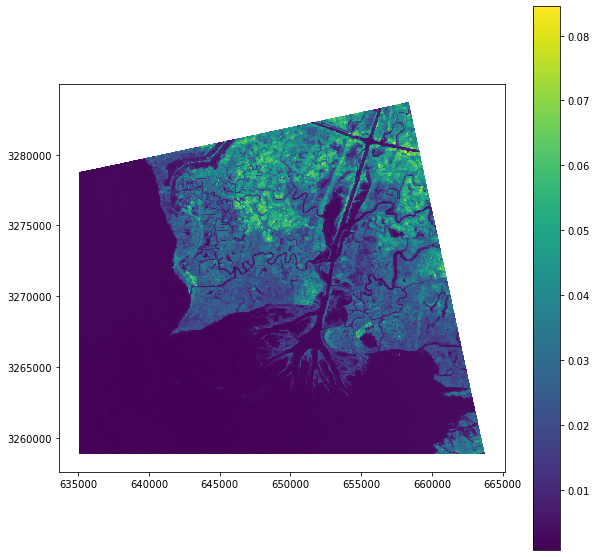

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
superpixel_analysis_df.plot(ax=ax, column='mean_hv', legend=True)

# Saving the Vector Data

We save our new geodataframe as a shapefile (or GeoJSON). However, it will take some time to write with so many columns.

In [14]:
superpixel_analysis_df.to_file(out_path/'superpixels_with_attributes_rasterstats')

/Users/cmarshak/anaconda3/lib/python3.7/site-packages/geopandas/io/file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
